In [1]:
import os
import re
import sys
import glob
import pickle
import tables
import datetime

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from comet_ml.api import API, APIExperiment
from comet_ml.query import Tag

if not '..' in sys.path:
    sys.path.append('..')
from train_LSTM import *

#### First, convert all the Excel spreadsheets to pickle files

In [2]:
def read_sheet(data_file, sheet_name, header=(0,)):
    df = pd.read_excel(data_file, sheet_name=sheet_name, parse_dates=True, header=header)
    
    if isinstance(df.columns, pd.MultiIndex):
        cols = []
        for col in df.columns.to_list():
            if 'Unnamed' in col[0]:
                cols.append(col[1])
            else:
                cols.append(col[0].split(' ')[-1] + '_' + col[1].split(' ')[0])
        df.columns = cols

    if 'date' in df.columns:
        year = df.date[0].year
        df['datetime'] = [pd.Timestamp(year=d.year, month=d.month, day=d.day, 
                                       hour=t.hour, minute=t.minute) for d,t in zip(df.date, df.time)]
        df.drop(['date', 'time'], axis=1, inplace=True)
    elif 'datetime (epoch)' in df.columns:
        datetimes = [time.gmtime(dt) for dt in df['datetime (epoch)']]
        year = datetimes[0].tm_year
        df['datetime'] = [pd.Timestamp(year = dt.tm_year, month = dt.tm_mon, day = dt.tm_mday, 
                                 hour = dt.tm_hour, minute  = dt.tm_min) for dt in datetimes]
        df.drop('datetime (epoch)', axis=1, inplace=True)

    df['weekday'] = [d.weekday() for d in df['datetime']]
    df['weekend'] = [d.weekday() in (5,6) for d in df['datetime']]
    df['holiday'] = False
    for holiday in bank_holidays[year]:
        idx = np.array([timestamp.month == holiday[0] and timestamp.day == holiday[1] \
                        for timestamp in df['datetime']])
        df.loc[idx, 'holiday'] = True

    cols = df.columns.tolist()
    cols = cols[-4:] + cols[:-4]
    df = df[cols]
    df.rename({col: col.split(' ')[0] for col in cols}, axis='columns', inplace=True)
    return df

In [3]:
data_folder = '../data/'
xls_files = ['data1.xlsx','data2.xlsx']
pkl_files = [os.path.splitext(xls_file)[0] + '.pkl' for xls_file in xls_files]
reload = False
data = {}
for xls_file, pkl_file in zip(xls_files, pkl_files):
    if not os.path.isfile(data_folder + pkl_file) or reload:
        building_energy = read_sheet(data_folder + xls_file, 'building_energy')
        building_sensor = read_sheet(data_folder + xls_file, 'building_sensor')
        weather_data = read_sheet(data_folder + xls_file, 'weather_data')
        zones = {i+1: read_sheet(data_folder + xls_file, sheet_name=f'zone#{i+1}_energy', 
                                 header=(0,1)) for i in range(5)}
        sensors = {i+1: read_sheet(data_folder + xls_file, sheet_name=f'zone#{i+1}_sensor') for i in range(3)}
        data = {'full': {
            'building_energy': building_energy,
            'building_sensor': building_sensor,
            'weather_data': weather_data,
            'zones': zones,
            'sensors': sensors
        }}
        pickle.dump(data, open(data_folder + pkl_file, 'wb'))
    blob = pickle.load(open(data_folder + pkl_file, 'rb'))
    for key1 in blob:
        if key1 not in data:
            data[key1] = blob[key1]
        else:
            for key2,value2 in blob[key1].items():
                if isinstance(value2, dict):
                    for key3,value3 in blob[key1][key2].items():
                        data[key1][key2][key3] = data[key1][key2][key3].append(value3, ignore_index=True)
                elif isinstance(value2, pd.DataFrame):
                    data[key1][key2] = data[key1][key2].append(value2, ignore_index=True)
                else:
                    raise Exception(f'Do not know how to deal with object of type {type(value2)}')

#### Load the best models

In [4]:
api = API(api_key = os.environ['COMET_API_KEY'])
workspace = 'danielelinaro'
project_name = 'load-forecasting'

future = 1    # [hours]
history = 24  # [hours]
hours_ahead = np.r_[0 : 24 : future]

n_neurons = 20
n_layers = 3
with_building_temperature = False
random_initial_weights = True
training_data_files = ['data1','data2']

base_query = Tag('LSTM') & Tag('_'.join(training_data_files)) & \
    Tag(f'future={future:.2f}') & Tag(f'history={history}')
if n_layers is not None:
    base_query &= Tag(f'{n_layers}_layers')
if n_neurons is not None:
    base_query &= Tag(f'{n_neurons}_neurons')
if with_building_temperature:
    base_query &= Tag('building_temperature')
if random_initial_weights:
    base_query &= Tag('random_initial_weights')
else:
    base_query &= Tag('initialized_weights')

experiments_path = '../experiments/LSTM/'
experiment_IDs = []
val_losses = []
for hours in hours_ahead:
    sys.stdout.write(f'{hours:4.2f} hours ahead ')
    sys.stdout.flush()
    query = base_query & Tag(f'ahead={hours:.1f}')
    experiments = api.query(workspace, project_name, query, archived=False)
    if not with_building_temperature:
        experiments = [expt for expt in experiments if all([tag != 'building_temperature' \
                                                            for tag in expt.get_tags()])]
    msg = f'({len(experiments)} expts): '
    n_char = len(msg)
    sys.stdout.write(msg)
    min_val_loss = 100
    for experiment in experiments:
        metrics = experiment.get_metrics_summary()
        loss = [float(m['valueMin']) for m in metrics if m['name'] == 'val_loss'][0]
        if loss < min_val_loss:
            ID = experiment.id
            history = pickle.load(open(experiments_path + ID + '/history.pkl','rb'))
            val_loss = history['val_loss']
            min_val_loss = loss
            tags = experiment.get_tags()
    experiment_IDs.append(ID)
    val_losses.append(val_loss)
    n_neurons = [int(tag.split('_')[0]) for tag in tags if 'neurons' in tag][0]
    n_layers = [int(tag.split('_')[0]) for tag in tags if 'layers' in tag][0]
    n_epochs = len(val_loss)
    print(f'best expt is {ID[:9]} ({n_layers} layers, {n_neurons} neurons, {n_epochs:3d} epochs), ' + 
          f'validation loss: {min_val_loss:.4f}')

 0 hours ahead (1 expts): best expt is bade6653b (3 layers, 20 neurons, 100 epochs), validation loss: 0.0765
 1 hours ahead (1 expts): best expt is 5bdc8bbba (3 layers, 20 neurons, 100 epochs), validation loss: 0.1091
 2 hours ahead (1 expts): best expt is 8b836f3cf (3 layers, 20 neurons, 100 epochs), validation loss: 0.1238
 3 hours ahead (1 expts): best expt is b766adc80 (3 layers, 20 neurons, 100 epochs), validation loss: 0.1354
 4 hours ahead (1 expts): best expt is 931a29e52 (3 layers, 20 neurons, 100 epochs), validation loss: 0.1464
 5 hours ahead (1 expts): best expt is 987d8a567 (3 layers, 20 neurons, 100 epochs), validation loss: 0.1472
 6 hours ahead (1 expts): best expt is 39b9b156b (3 layers, 20 neurons, 100 epochs), validation loss: 0.1592
 7 hours ahead (1 expts): best expt is dd2ba4871 (3 layers, 20 neurons, 100 epochs), validation loss: 0.1514
 8 hours ahead (1 expts): best expt is 8dba116a2 (3 layers, 20 neurons, 100 epochs), validation loss: 0.1572
 9 hours ahead (1 e

In [5]:
n_experiments = len(experiment_IDs)
models = []
for i,experiment_ID in enumerate(experiment_IDs):
    checkpoint_path = experiments_path + experiment_ID + '/checkpoints/'
    checkpoint_files = glob.glob(checkpoint_path + '*.h5')
    epochs = [int(os.path.split(file)[-1].split('.')[1].split('-')[0])
              for file in checkpoint_files]
    best_checkpoint = checkpoint_files[epochs.index(np.argmin(val_losses[i]) + 1)]
    models.append(keras.models.load_model(best_checkpoint, compile=True))

parameters = pickle.load(open(experiments_path + experiment_ID + '/parameters.pkl', 'rb'))
# we need min and max of the training set to normalize the data
training_set_min = parameters['training_set_min']
training_set_max = parameters['training_set_max']
try:
    data_files = ['../' + data_file for data_file in parameters['data_files']]
except:
    data_files = ['../' + parameters['data_file']]
time_step = parameters['time_step']

In [6]:
input_file = '../data/data2.pkl'
ext = os.path.splitext(input_file)[1]
data_full = pickle.load(open(input_file, 'rb'))['full']
data = data_full['building_energy'].copy()
if 'building_consumption' in parameters['inputs']['continuous']:
    data.rename({key: 'building_' + key for key in ('consumption','generation')},
                axis='columns', inplace=True)
data['building_temperature'] = data_full['building_sensor']['temperature'].copy()
orig_time_step = extract_time_step(data)
data = add_minute_and_workday(data)
data = average_data(data, time_step, orig_time_step, parameters['inputs']['continuous'])
n_days, samples_per_day = compute_stats(data, time_step)
past_samples = samples_per_day * parameters['history_size'] // 24
t_past = np.arange(past_samples) * time_step / 60
t_past -= t_past[-1]
t_future = np.arange(samples_per_day) * time_step / 60

print(f'Time step: {time_step} minutes.')
print(f'Number of days: {n_days}.')
print(f'Samples per day: {samples_per_day}.')

Time step: 15 minutes.
Number of days: 40.
Samples per day: 96.


In [7]:
cols = parameters['inputs']['continuous']
if parameters['average_continuous_inputs']:
    cols = [col + '_averaged' for col in cols]
X = make_dataset(data, cols, parameters['inputs']['categorical'],
                training_set_max, training_set_min, n_days, samples_per_day)
print(f'The input matrix has {X.shape[0]} rows and {X.shape[1]} columns.')

The input matrix has 3840 rows and 107 columns.


In [8]:
fun = lambda y,M,m: (m + (M - m) / 2 * (y + 1)) * 1e-3
past_measured_scaled = tf.constant(X[-past_samples:, :][np.newaxis, :, :], dtype=tf.float32)
past_measured = fun(past_measured_scaled[0,:,0], training_set_max[0], training_set_min[0])
future_predicted_scaled = np.ndarray.flatten(
    np.concatenate([model.predict(past_measured_scaled) for model in models]))
future_predicted = fun(future_predicted_scaled, training_set_max[0], training_set_min[0])

In [38]:
dt = data['datetime'].iloc[-1]
year = dt.year
month = dt.month
day = dt.day + 1
dates = [f'{day:02d}/{month:02d}/{year}' for _ in range(samples_per_day - 1)]
dates.append(f'{day+1:02d}/{month:02d}/{year}')
hours = []
for suffix in 'AM','PM':
    for hour in [12] + list(range(1, 12)):
        for i in range(60 // time_step):
            hours.append(f'{hour}:{i*time_step:02d}:00 {suffix}')
hours = hours[1:] + hours[:1]
with pd.ExcelWriter(f'{year}{month:02d}{day:02d}.xlsx') as writer:
    df = pd.DataFrame({
        'date': dates,
        'time': hours,
        'consumption (w)': future_predicted * 1e3
    })
    df.to_excel(writer, sheet_name='building_energy', index=False)
df.head()

,date,time,consumption (w)
0,10/02/2020,12:15:00 AM,1759.874756
1,10/02/2020,12:30:00 AM,1750.446167
2,10/02/2020,12:45:00 AM,1767.991089
3,10/02/2020,1:00:00 AM,1752.180054
4,10/02/2020,1:15:00 AM,1815.009644


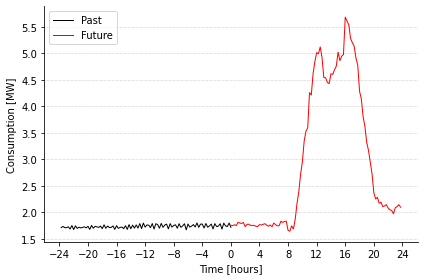

In [39]:
fig,ax = plt.subplots(1, 1)
ax.plot(t_past, past_measured, 'k', lw=1, label='Past')
ax.plot(t_future, future_predicted, 'r', lw=1, label='Future')
ax.legend(loc='best')
dt = 4
ax.set_xticks(np.arange(t_past[0] - time_step / 60, t_future[-1] + dt/2, dt))
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Consumption [MW]')
for side in 'right','top':
    ax.spines[side].set_visible(False)
ax.grid(which='major', axis='y', color=[.6,.6,.6], lw=0.5, linestyle=':')
fig.tight_layout()